In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import glob

import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Data Preprocessing

In [2]:
data_path = "/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/source_images"

def rename_images(base_path):

    subfolders = [f for f in os.listdir(base_path)]

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_path, subfolder)

        files = glob.glob(os.path.join(subfolder_path, "*"))

        for i, file_path in enumerate(files):
            _, ext = os.path.splitext(file_path)
            new_path = os.path.join(subfolder_path, f"{subfolder}_{i}{ext}")
            os.rename(file_path, new_path)

rename_images(data_path)

In [3]:
def load_and_preprocess_images(data_path, target_size=(64, 64)):
    images = []
    labels = []
    label_map = {}
    
    # Get all subfolders (classes)
    subfolders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    
    # Create label mapping
    for idx, folder in enumerate(subfolders):
        label_map[folder] = idx
    
    # Load and preprocess images from each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_path, subfolder)
        files = glob.glob(os.path.join(subfolder_path, "*"))
        
        for file_path in tqdm.tqdm(files, desc=f"Processing {subfolder}"):
            # Load image
            img = Image.open(file_path).convert('RGB')  # Ensure RGB format
            
            # Resize
            img = img.resize(target_size, Image.LANCZOS)
            
            # Convert to numpy array and normalize
            img_array = np.array(img) / 255.0
            
            images.append(img_array)
            labels.append(label_map[subfolder])
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    # Reshape for PyTorch (N, C, H, W)
    X = X.transpose(0, 3, 1, 2)  # Rearrange from (N, H, W, C) to (N, C, H, W)
    
    return X, y, label_map

# Load and preprocess all images
X, y, label_map = load_and_preprocess_images(data_path)

# First split into train and temp (80-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split temp into validation and test (50-50, meaning 10-10 of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nClass mapping: {label_map}")


Processing cassette_player: 100%|██████████| 500/500 [00:00<00:00, 1378.43it/s]


Training set shape: torch.Size([3804, 3, 64, 64])
Validation set shape: torch.Size([475, 3, 64, 64])
Test set shape: torch.Size([476, 3, 64, 64])

Class mapping: {'chainsaw': 0, 'gas_pump': 1, 'tench': 2, 'french_horn': 3, 'church': 4, 'english_springer': 5, 'golf_ball': 6, 'garbage_truck': 7, 'parachute': 8, 'cassette_player': 9}


In [4]:
# Create data loaders
batch_size = 32

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model Architecture

In [5]:
class ObjectRecognition(nn.Module):
    def __init__(self):
        super(ObjectRecognition, self).__init__()
        # Input is RGB (3 channels) and 224x224 based on error message dimensions
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 112x112x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 56x56x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 28x28x128

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.2)

        # After 3 max pooling layers (divide by 2^3 = 8): 28x28x128
        self.fc1 = nn.Linear(8192, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes based on the data shown

        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: Bx3x224x224 
        x = self.mp1(self.relu(self.bn1(self.conv1(x))))  # Bx32x112x112
        x = self.mp2(self.relu(self.bn2(self.conv2(x))))  # Bx64x56x56
        x = self.mp3(self.relu(self.bn3(self.conv3(x))))  # Bx128x28x28

        x = torch.flatten(x, 1)  # Bx(128*28*28)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))  # Bx512
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # Bx128
        x = self.fc3(x)  # Bx10

        return x

# Training

In [6]:
model = ObjectRecognition()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 15

Epoch 1/15: 100%|██████████| 119/119 [00:12<00:00,  9.33it/s, loss=1.85]


Epoch [1/15] - Loss: 1.8847


Epoch 2/15: 100%|██████████| 119/119 [00:11<00:00, 10.06it/s, loss=1.38]


Epoch [2/15] - Loss: 1.4451


Epoch 3/15: 100%|██████████| 119/119 [00:11<00:00, 10.04it/s, loss=1.37] 


Epoch [3/15] - Loss: 1.2207


Epoch 4/15: 100%|██████████| 119/119 [00:12<00:00,  9.85it/s, loss=1.43] 


Epoch [4/15] - Loss: 1.0473


Epoch 5/15: 100%|██████████| 119/119 [00:11<00:00,  9.97it/s, loss=0.67] 


Epoch [5/15] - Loss: 0.9040


Epoch 6/15: 100%|██████████| 119/119 [00:11<00:00, 10.06it/s, loss=0.966]


Epoch [6/15] - Loss: 0.7984


Epoch 7/15: 100%|██████████| 119/119 [00:11<00:00,  9.97it/s, loss=0.953]


Epoch [7/15] - Loss: 0.7063


Epoch 8/15: 100%|██████████| 119/119 [00:12<00:00,  9.81it/s, loss=0.474]


Epoch [8/15] - Loss: 0.6012


Epoch 9/15: 100%|██████████| 119/119 [00:11<00:00, 10.06it/s, loss=0.591]


Epoch [9/15] - Loss: 0.5141


Epoch 10/15: 100%|██████████| 119/119 [00:11<00:00, 10.00it/s, loss=0.551]


Epoch [10/15] - Loss: 0.4505


Epoch 11/15: 100%|██████████| 119/119 [00:11<00:00,  9.97it/s, loss=0.385]


Epoch [11/15] - Loss: 0.3829


Epoch 12/15: 100%|██████████| 119/119 [00:11<00:00,  9.92it/s, loss=0.44] 


Epoch [12/15] - Loss: 0.3211


Epoch 13/15: 100%|██████████| 119/119 [00:12<00:00,  9.89it/s, loss=0.12] 


Epoch [13/15] - Loss: 0.2733


Epoch 14/15: 100%|██████████| 119/119 [00:12<00:00,  9.80it/s, loss=0.243]


Epoch [14/15] - Loss: 0.2396


Epoch 15/15: 100%|██████████| 119/119 [00:11<00:00, 10.05it/s, loss=0.0976]


Epoch [15/15] - Loss: 0.1874


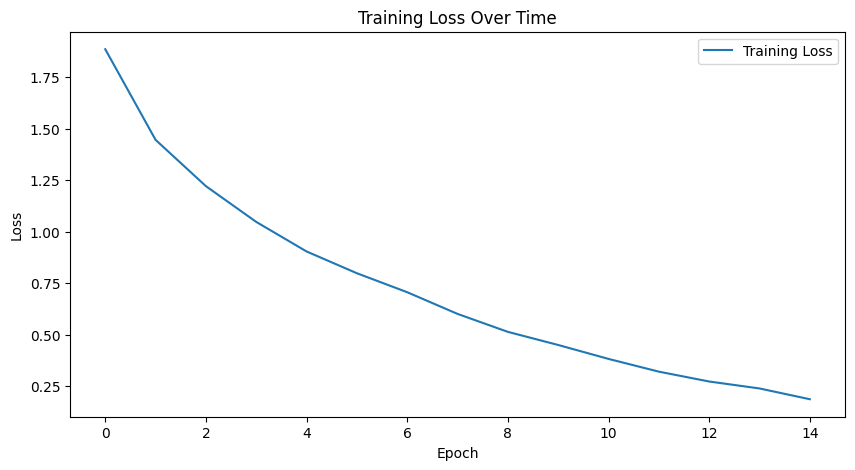

In [8]:
# Training loop
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Progress bar for training batches
    progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for images, labels in progress_bar:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'loss': loss.item()})
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Download model weights

In [14]:
# # Save model weights
# model_save_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_15_epochs.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model weights saved to {model_save_path}")

Model weights saved to /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object_detection/model_weights_15_epochs.pth


# Validation

In [7]:
# Load saved model weights
model_weights_path = '/Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object-detection-nonadversarial/model_weights.pth'
model.load_state_dict(torch.load(model_weights_path))
print(f"Model weights loaded from {model_weights_path}")

Model weights loaded from /Users/olicho/Desktop/Programming/adversarial-style-transfer/models-weights/object-detection-nonadversarial/model_weights.pth


In [8]:
def evaluate_model(model, test_loader):

    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader)

    return {
        'loss': test_loss,
        'accuracy': correct / total,
    }

# Evaluate model on test set
test_results = evaluate_model(model, test_loader)
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")

Test Loss: 0.3066
Test Accuracy: 0.9370


# Evaluate on a stylized image

In [27]:
class_names = list(label_map.keys())

# Load and preprocess the image
golfball = Image.open('/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/random-test/golfball_0.jpg')
golfball = Image.open('/Users/olicho/Desktop/Programming/adversarial-style-transfer/data/source_images/golf_ball/golf_ball_0.JPEG')
golfball = golfball.convert('RGB')  # Ensure RGB format

# Resize
golfball = golfball.resize((64, 64), Image.LANCZOS)

# Convert to numpy array and normalize 
golfball_array = np.array(golfball) / 255.0

# Reshape for PyTorch (N, C, H, W)
golfball_tensor = torch.from_numpy(golfball_array.transpose(2, 0, 1)).float()
golfball_tensor = golfball_tensor.unsqueeze(0)  # Add batch dimension

# Evaluate model
model.eval() 
with torch.no_grad():
    output = model(golfball_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    
    # Get top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)
    
    print("Top 3 predictions:")
    for i in range(3):
        print(f"{i+1}. {class_names[top3_idx[i]]}: {top3_prob[i]:.2%}")

Top 3 predictions:
1. golf_ball: 98.74%
2. tench: 1.23%
3. english_springer: 0.02%
